In this notebook, we will introduce the basics of sovling a regression problem. The data we use for this demo is the ["Computer Hardware Data Set"](http://archive.ics.uci.edu/ml/datasets/Computer+Hardware) from the UCI machine learning repository.

> Note: It is recommended to go through the tutorial on basics of classification before reading this article. Some basic notations won't be repeated here.

The dataset contains a set of 209 records under 9 attributes. For more information about the data set, please visit the UCI website.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

## Reading data from files

The data file is a text file named as `machine.data`. We cannot infer the data type from the file extension. We can load the file to peek the first few lines.

In [2]:
with open('machine.data', 'r') as f:
    for _ in range(5):
        print(f.readline(), end='')

adviser,32/60,125,256,6000,256,16,128,198,199
amdahl,470v/7,29,8000,32000,32,8,32,269,253
amdahl,470v/7a,29,8000,32000,32,8,32,220,253
amdahl,470v/7b,29,8000,32000,32,8,32,172,253
amdahl,470v/7c,29,8000,16000,32,8,16,132,132


It looks like the data is separated by commas, so we can read the 

In [3]:
df = pd.read_csv('machine.data', header=None)

Again, we can take a quick look at the data by using the `head` method:

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


From the UCI website, we can get the following attribute Information:

1. vendor name: 30 
      (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, 
       dg, formation, four-phase, gould, honeywell, hp, ibm, ipl, magnuson, 
       microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry, 
       sratus, wang)
2. Model Name: many unique symbols
3. MYCT: machine cycle time in nanoseconds (integer)
4. MMIN: minimum main memory in kilobytes (integer)
5. MMAX: maximum main memory in kilobytes (integer)
6. CACH: cache memory in kilobytes (integer)
7. CHMIN: minimum channels in units (integer)
8. CHMAX: maximum channels in units (integer)
9. PRP: published relative performance (integer)
10. ERP: estimated relative performance from the original article (integer)

We can assign names to different columns by:

In [5]:
df.columns = ['Vendor name', 'Model name', 'MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP']
df.head()

,Vendor name,Model name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


The column PRP is our target variable, and the ERP is the estimated value. We won't be using the ERP column, so drop this column:

In [6]:
df.drop(columns=['ERP'], inplace=True)

## Explore data

Some exploration is usually required before training any machine learning models. Some basic questions include:

* How large is the data set?
* How many features (attributes)? What is the distribution of each feature?
* What is the distribution of class labels? Are the labels imbalanced?

The size of the data table can be accessed with the `shape` attribute of data frame:

In [7]:
df.shape

(209, 9)

It shows us that the data set has 209 measurements.

Distribution of features:

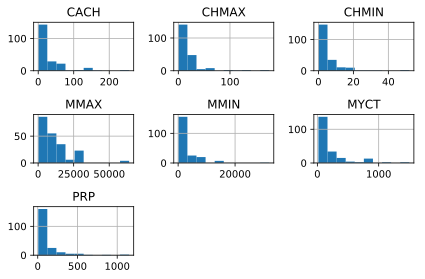

In [8]:
df.hist(bins=10)
plt.tight_layout()

The `describe` method provides useful statistical information on the numerical columns of the data set:

In [9]:
df.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000


Again, we can use the `value_counts` method to count the number of data points for each vendor:

In [10]:
df['Vendor name'].value_counts()

ibm             32
nas             19
honeywell       13
sperry          13
ncr             13
siemens         12
cdc              9
amdahl           9
burroughs        8
harris           7
hp               7
dg               7
c.r.d            6
magnuson         6
ipl              6
dec              6
formation        5
cambex           5
prime            5
gould            3
perkin-elmer     3
nixdorf          3
apollo           2
bti              2
basf             2
wang             2
microdata        1
sratus           1
adviser          1
four-phase       1
Name: Vendor name, dtype: int64

## Build the regression model

The data is already in a very good quality so there is not much data cleaning to do. With the data ready, let's build the first machine learning model.

First define a regressor object. We will be using the simplest linear regression model:

In [11]:
X = df[['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']].values
y = df['PRP'].values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)

pred = reg.predict(X_test)

For regression problem, we have different metrics from the classification problem:

In [13]:
mean_squared_error(y_test, pred)

5633.068155793257

It is usually easier to visualize the regression performance by plot:

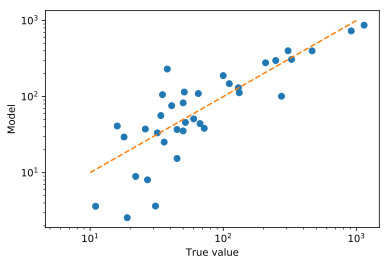

In [14]:
plt.plot(y_test, pred, 'o')
plt.plot([10, 1000], [10, 1000], '--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('True value')
plt.ylabel('Model');

The orange line shows the performance of an ideal model (where Model = True value). The farther away of points to the orange line, the worse the model. Therefore, we can use this plot to quickly get an idea of the model performance, which is more intuitive and sometimes better than simply looking at the numerical metrics like mean square error.